<a href="https://colab.research.google.com/github/Aydyou/Sentiment-analysis-on-Q10-reports-using-BERT/blob/master/bertfin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 778kB 6.2MB/s 
     |████████████████████████████████| 890kB 11.2MB/s 
     |████████████████████████████████| 1.1MB 40.1MB/s 
     |████████████████████████████████| 3.0MB 44.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=8dc7458ea03c4ded6516d46c2bd8d9ee8f7a89ab9a00635adff0dc84ad996900
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import torch
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import os 
dir_path = os.getcwd()
print(dir_path)
prefix = dir_path+'/drive/My Drive/Colab Notebooks/train.csv'


train_df = pd.read_csv(prefix, header=None,  engine='python')
train_df[0].replace({"neutral": int(1), "negative": int(0), "positive": int(2)}, inplace=True)
train_df.head()



/content


,0,1
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,0,The international electronic industry company ...
3,2,With the new production plant the company woul...
4,2,According to the company 's updated strategy f...


In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import logging
logging.basicConfig(level=logging.ERROR)
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [5]:
token_lens = []
for txt in train_df[1]:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

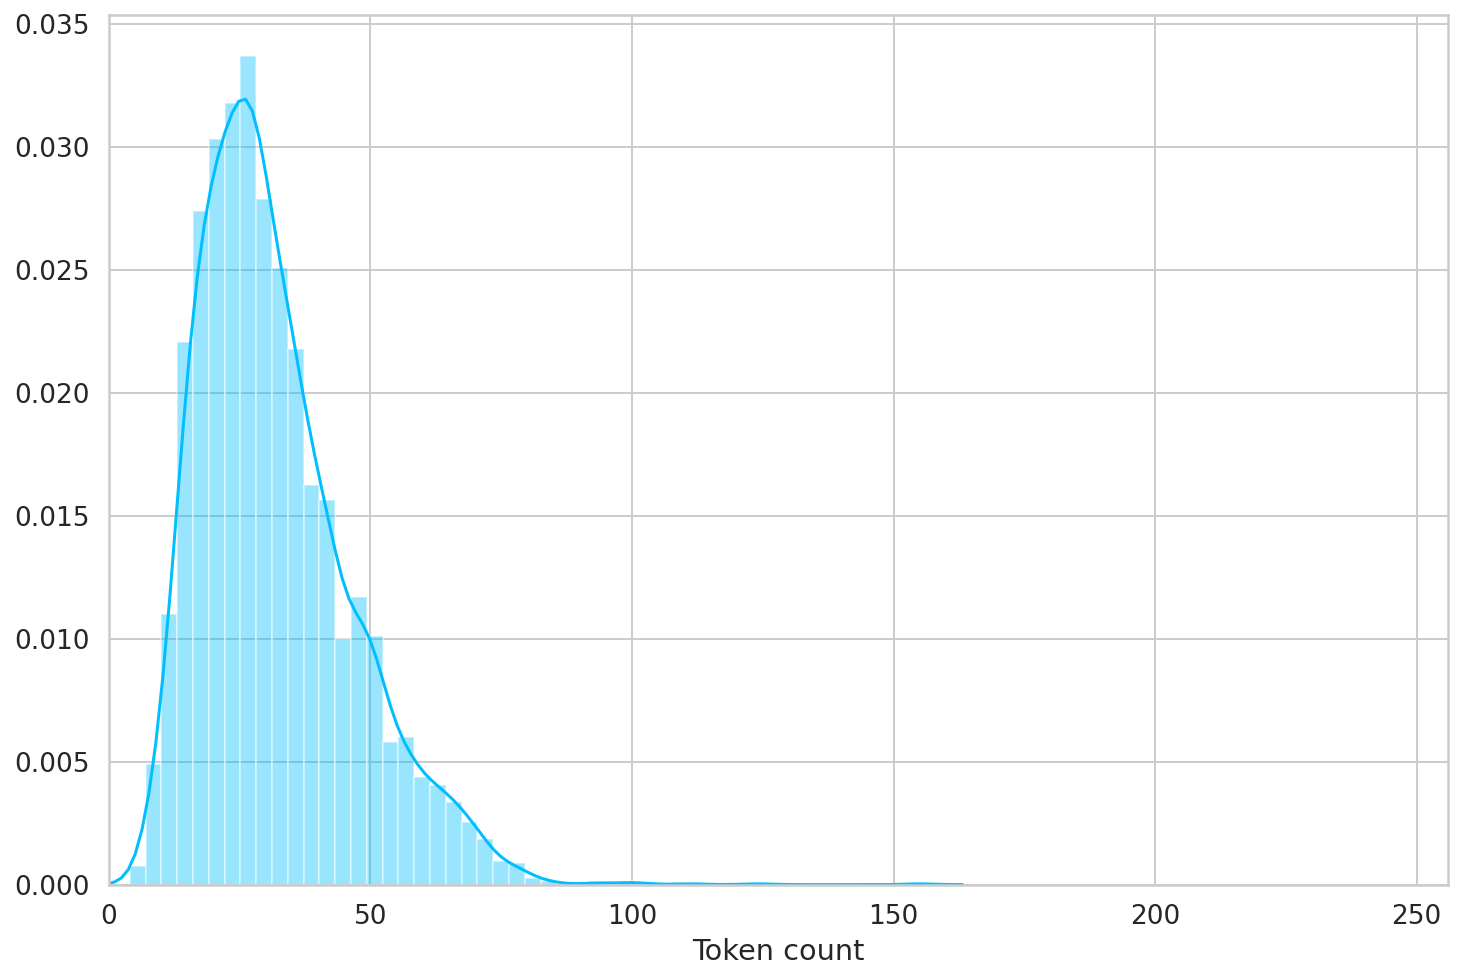

In [6]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

In [7]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.reviews)
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
        return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [8]:
df_train, df_test = train_test_split(
  train_df,
  test_size=0.1,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [9]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
    reviews=df[1].to_numpy(),
    targets=df[0].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )
    return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=0
  )
BATCH_SIZE = 16
MAX_LEN=160
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [10]:
data = next(iter(train_data_loader))
data.keys()


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [11]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [12]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
        output = self.drop(pooled_output)
        return self.out(output)

In [13]:
class_names = ['negative', 'neutral', 'positive']

model = SentimentClassifier(len(class_names))
model = model.to(device)

In [14]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3390, 0.3936, 0.2674],
        [0.5897, 0.1692, 0.2411],
        [0.5177, 0.2080, 0.2743],
        [0.6593, 0.1191, 0.2216],
        [0.4457, 0.2212, 0.3331],
        [0.3677, 0.4450, 0.1873],
        [0.4353, 0.2551, 0.3096],
        [0.3915, 0.2213, 0.3872],
        [0.4893, 0.2030, 0.3077],
        [0.5974, 0.1591, 0.2435],
        [0.2067, 0.3114, 0.4819],
        [0.4825, 0.2453, 0.2721],
        [0.5238, 0.1458, 0.3303],
        [0.4334, 0.3034, 0.2632],
        [0.4806, 0.1874, 0.3319],
        [0.5868, 0.1092, 0.3039]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [15]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [16]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [17]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

#### Training


history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.54581215238069 accuracy 0.7741343728502637
Val   loss 0.3108216901309788 accuracy 0.8760330578512396

Epoch 2/10
----------
Train loss 0.256187148801573 accuracy 0.9087365283191928
Val   loss 0.3546175993978977 accuracy 0.8842975206611571

Epoch 3/10
----------
Train loss 0.12936340451868245 accuracy 0.9633111671634946
Val   loss 0.5982276033610106 accuracy 0.871900826446281

Epoch 4/10
----------
Train loss 0.07653171671452103 accuracy 0.978445310708553
Val   loss 0.7297231927514076 accuracy 0.8677685950413223

Epoch 5/10
----------
Train loss 0.04063618296544978 accuracy 0.9889933501490483
Val   loss 0.7305189296603203 accuracy 0.8801652892561984

Epoch 6/10
----------
Train loss 0.027410385645789542 accuracy 0.9935794542536115
Val   loss 0.7445324929431081 accuracy 0.8842975206611571

Epoch 7/10
----------
Train loss 0.01685563037014181 accuracy 0.9951845906902086
Val   loss 0.7860968569293618 accuracy 0.8842975206611571

Epoch 8/10
----------
Trai

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.13991769547325103

In [18]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [19]:
### Load the saved model

model = SentimentClassifier(len(class_names))
model = model.to(device)
model.load_state_dict(torch.load(dir_path+'/drive/My Drive/Colab Notebooks/best_model_state.bin'))

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.84      0.91      0.87        34
     neutral       0.94      0.88      0.91       132
    positive       0.84      0.90      0.87        77

    accuracy                           0.89       243
   macro avg       0.87      0.90      0.88       243
weighted avg       0.89      0.89      0.89       243



In [ ]:
print(y_test)
print(y_pred)
print(y_pred_probs)

tensor([2, 1, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1,
        0, 2, 2, 2, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1,
        1, 0, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 2, 1, 2, 1, 1,
        1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 0, 1, 0, 2, 0, 1, 1, 1, 2, 1, 2, 1,
        0, 2, 2, 1, 1, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 0, 2, 2, 1, 1, 2, 0, 1, 1, 2, 0, 1, 1, 0, 1, 2,
        2, 1, 0, 1, 2, 1, 2, 1, 0, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 0, 1, 2,
        2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 2, 0, 1, 2, 2,
        1, 2, 1, 2, 1, 1, 1, 1, 2, 0, 1, 2, 2, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 2,
        0, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 1, 2, 1, 0, 1, 2, 0, 1, 2, 2, 1, 1,
        1, 2, 1])
tensor([2, 1, 2, 0, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 2, 0, 1, 1, 1,
        0, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 1, 2, 2, 2, 0, 2, 1, 1, 1,
        2, 0, 2, 2, 0,

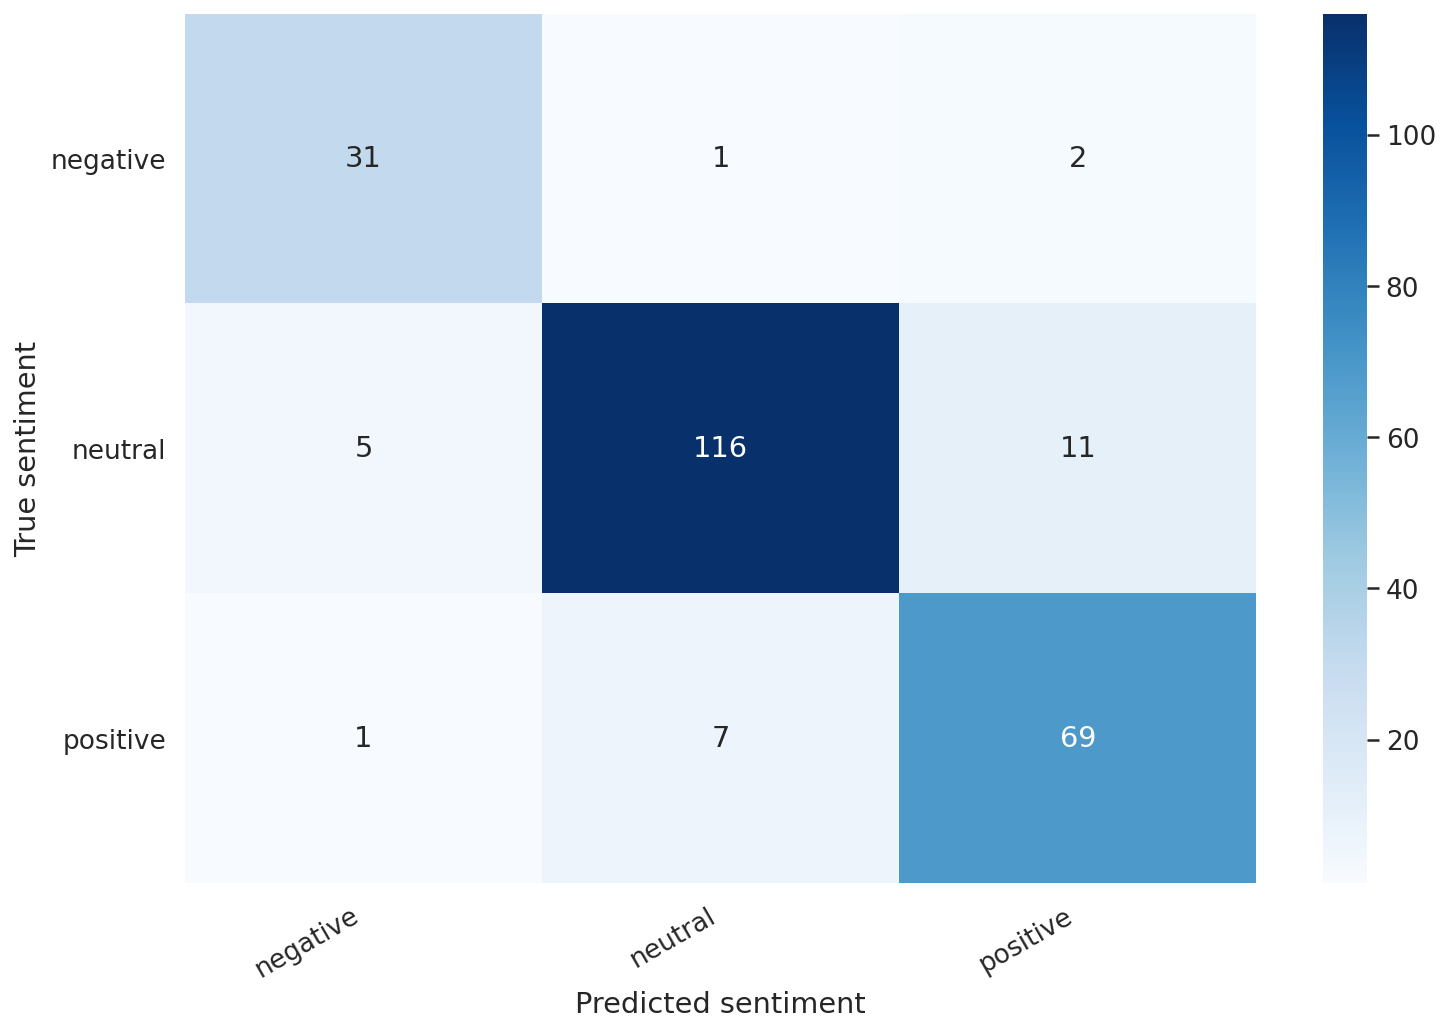

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
review_text = "40 million workers have filed for unemployment benefits since the early days of the coronavirus  "

encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')


Review text: 40 million workers have filed for unemployment benefits since the early days of the coronavirus  
Sentiment  : negative
tensor([[ 2.4858, -0.3942, -2.7369]], device='cuda:0', grad_fn=<AddmmBackward>)


In [20]:
### This calculates the sentiment score. 0 is extremely negative and 2 is extremely positive. 1 is neutral.
def sentiment_score(text):

  encoded_review = tokenizer.encode_plus(
  text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)
  input_ids = encoded_review['input_ids'].to(device)
  attention_mask = encoded_review['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)

  return  float(F.softmax(output)[0][0])*0+float(F.softmax(output)[0][1])*1+float(F.softmax(output)[0][2])*2




Now that we have trained the sentiment analyzer and made our sentiment_score function, we can go and scrape data from q10 reports and assign scores to them. We'll start with Apple. Our plan is to gather quarterly data for the last 10 years.

In [22]:
### This function grabs the link of pdf file and return the sentiment score.
!pip install textract
import requests
import re
from urllib.request import urlopen
from bs4 import BeautifulSoup
from pathlib import Path
#!pip install textract
import textract

def getscore_of_pdf_link(url):
  filename = Path('downloadedpdf.pdf')
  r=requests.get(url)
  filename.write_bytes(r.content)
  text = textract.process("/content/downloadedpdf.pdf")
  pat = r'(?<=\\n).+?(?=\.)'
  paragraphs=re.findall(pat, str(text))
  scorelist=[]
  for i in paragraphs:
    scorelist.append(sentiment_score(i))
  return np.mean(scorelist)




     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 112kB 18.0MB/s 
     |████████████████████████████████| 102kB 10.2MB/s 
     |████████████████████████████████| 32.8MB 89kB/s 
     |████████████████████████████████| 8.9MB 41.1MB/s 
     |████████████████████████████████| 5.6MB 34.5MB/s 
     |████████████████████████████████| 112kB 43.4MB/s 
     |████████████████████████████████| 81kB 9.9MB/s 
     |████████████████████████████████| 112kB 47.0MB/s 
     |████████████████████████████████| 143kB 44.5MB/s 
     |████████████████████████████████| 13.7MB 239kB/s 
  Created wheel for python-pptx: filename=python_pptx-0.6.18-cp36-none-any.whl size=275706 sha256=249c47012d0e5ee1e8a9571067632f8e0441ab3e229718a9c2e34f8a9784d8d6
  Stored in directory: /root/.cache/pip/wheels/1f/1f/2c/29acca422b420a0b5210bd2cd7e9669804520d602d2462f20b
  Created wheel for EbookLib: filename=EbookLib-0.17.1-cp36-none-any.whl size=38164 sha256=9fbcc3eb593a2001e5af7f10fa1a

In [ ]:
### This the list of links for Apple's quarterly reports for the past 10 years. Starting from 2010

apllinklist=['https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/427a9224-df7d-45bc-bc55-6ec47ca7c1be.pdf','https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/e0b72200-51ff-4542-bd14-dc2d6ae593e4.pdf',
             'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/8a1a8d70-7d9d-4d13-8939-1bdda30c79eb.pdf','https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/5b52af1e-f5eb-4c1e-93ee-1fd00587d040.pdf',
             'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/8c0bdff4-ba47-41c5-ac33-9ef9e70e3cf7.pdf', 'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/14da82c1-1dd4-47b7-b41c-459c3d6cc63e.pdf',
             'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/65139c81-7eae-4c66-8295-ec7f6a19031b.pdf', 'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/2f00b0bc-9949-470f-88fd-dbbb7fec305c.pdf',
             'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/94f176c2-5cd6-4d52-a974-95927350627a.pdf', 'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/94782571-2c76-4eed-a0cf-d60921550201.pdf',
             'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/fe793509-3ac6-44ef-93ba-35efc851f92a.pdf', 'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/b6312a1d-f759-4ec3-9b7b-4da62db37189.pdf',
             'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/a4ec00ef-590c-48c9-9363-6daf5cf6eaf3.pdf', 'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/989f4684-3454-4059-90da-23f439406206.pdf',
             'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/f3d826d0-1878-44fc-9e76-8387fe1ef220.pdf', 'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/a8547cc9-70c7-4f65-9465-01d474741c42.pdf',
             'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/b3ec6a0f-27be-459a-a45e-660b9ad148ae.pdf', 'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/e8898d8f-43a8-4aa9-9bf3-6fb81de6814e.pdf',
             'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/98a8c764-9824-4216-8ed6-820e413d1ed4.pdf', 'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/03458ba7-a985-47da-8e28-b03af2a7ca9c.pdf',
             'https://d1lge852tjjqow.cloudfront.net/CIK-0000320193/e34a7fee-1124-43c2-a597-16a9854c780a.pdf', 'https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/2ffa9a14-a535-4539-9b33-2e722d0c5fbc.pdf',
             'https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/5e5082da-1dc0-4f11-a3f3-9bd0353d590a.pdf', 'https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/5322e36f-074f-4781-b272-3f0e4cf6bcfd.pdf',
             'https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/9d7a4d29-df29-4d5a-af4e-d08e178ef7b3.pdf', 'https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/887c42b7-0ced-4192-957d-26f058a1d56e.pdf',
             'https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/3ec770b8-64e5-4f75-833c-386b0ed1c067.pdf', 'https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/8f91c57f-9dbf-48c4-889c-792e2acc05d4.pdf',
             'https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/109a6139-188d-49ac-9be4-a9c78e3944e9.pdf', 'https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/499ace4c-98d0-4975-9390-0caf217e7c85.pdf',
             'https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/e41a9e76-4aaf-4247-bdff-3238584a5728.pdf', 'https://d18rn0p25nwr6d.cloudfront.net/CIK-0000320193/ba1cb814-58aa-4cfc-889b-16c800b712c2.pdf']

In [ ]:
aplscorelist=[]
for i in apllinklist:
  j=getscore_of_pdf_link(i)
  print(j)
  aplscorelist.append(j)

In [ ]:
print(aplscorelist)

[1.0006453340756707, 1.000646100321319, 1.0006476864800788, 1.000640379206743, 1.000650047964882, 1.0006491788080893, 1.000638964411337, 1.0006430561770685, 1.000644829531666, 1.000639320409391, 1.0006454579415731, 1.0006506756762974, 1.0001341864117421, 1.0001413960126229, 1.0001429071999155, 1.0001353246043436, 1.000132197572384, 0.9105476402848932, 0.8979628956807385, 0.9220134964934857, 0.8970822482040168, 0.8993688232012158, 0.9032695115630865, 0.9888201222130533, 0.9172728567625287, 0.9152695530350234, 0.9028927052052732, 0.8949285970796218, 0.8913025432076973, 0.8982473735188398, 0.9893867286767288, 0.9710836911426668]


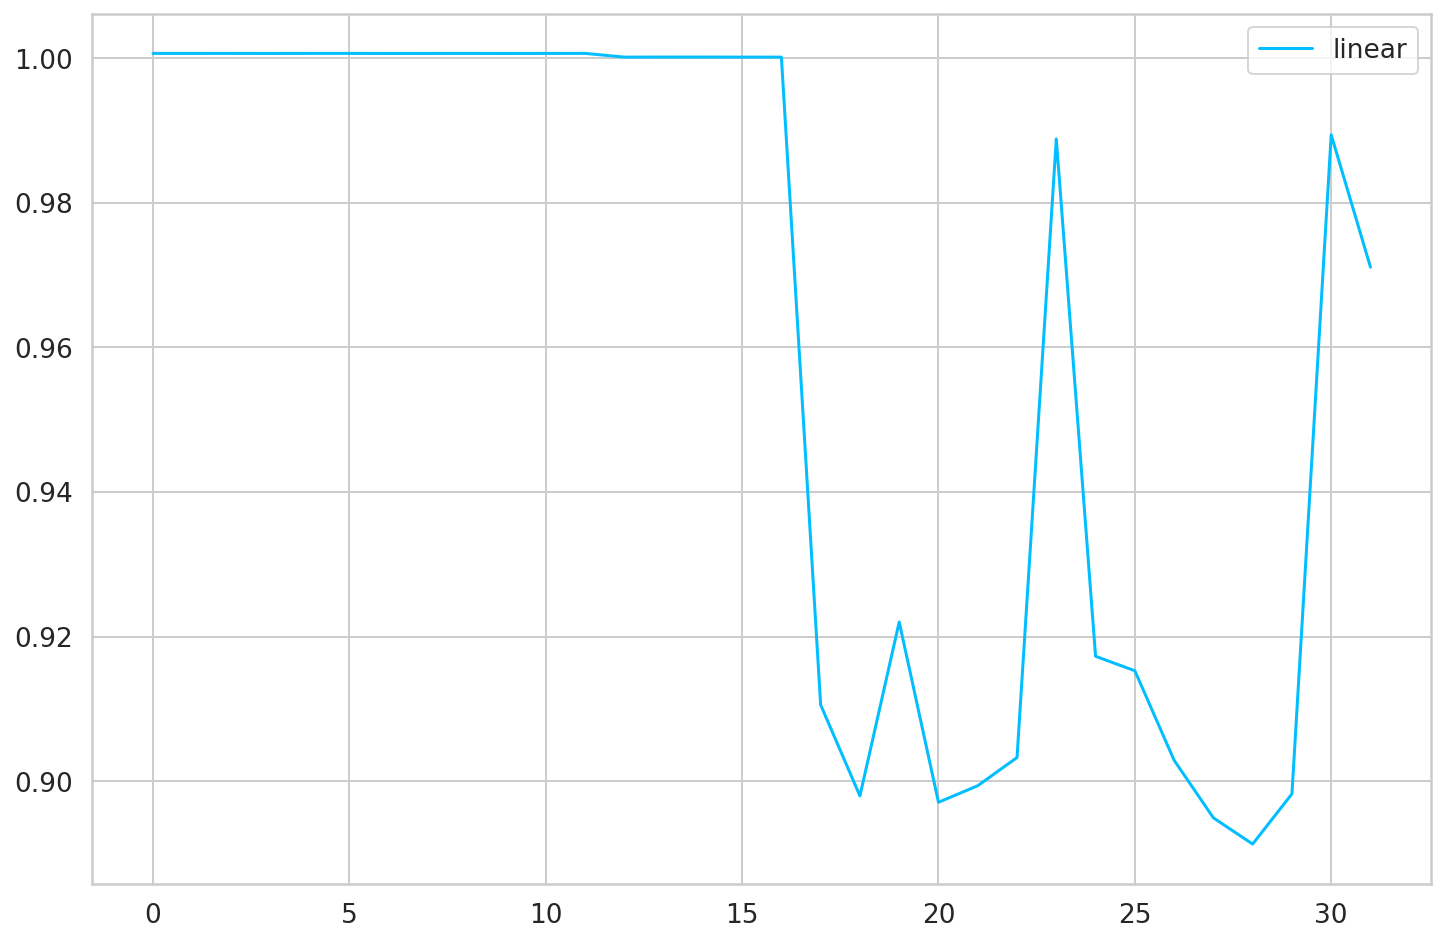

In [23]:
aplscorelist=[1.0006453340756707, 1.000646100321319, 1.0006476864800788, 1.000640379206743, 1.000650047964882, 1.0006491788080893, 1.000638964411337, 1.0006430561770685, 1.000644829531666, 1.000639320409391, 1.0006454579415731, 1.0006506756762974, 1.0001341864117421, 1.0001413960126229, 1.0001429071999155, 1.0001353246043436, 1.000132197572384, 0.9105476402848932, 0.8979628956807385, 0.9220134964934857, 0.8970822482040168, 0.8993688232012158, 0.9032695115630865, 0.9888201222130533, 0.9172728567625287, 0.9152695530350234, 0.9028927052052732, 0.8949285970796218, 0.8913025432076973, 0.8982473735188398, 0.9893867286767288, 0.9710836911426668]
# Plot the data
plt.plot(aplscorelist, label='linear')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [59]:
import pandas_datareader.data as web

apple = web.get_data_yahoo('AAPL','01/01/2010',interval='m')
L=['2010-02-01','2010-05-01', '2010-08-01', '2011-02-01', '2011-05-01', '2011-08-01', '2012-02-01', '2012-05-01', '2012-08-01', '2013-02-01', '2013-05-01',
                                 '2013-08-01','2014-02-01', '2014-05-01', '2014-08-01', '2015-02-01', '2015-05-01', '2015-08-01',
                                 '2016-02-01','2016-05-01', '2016-08-01','2017-02-01', '2017-05-01', '2017-08-01', '2018-02-01', '2018-05-01', '2018-08-01', '2019-02-01', '2019-05-01',
                                 '2019-08-01','2020-02-01', '2020-05-01']

df_apple = pd.DataFrame({'date': L,'sentiment': aplscorelist})
df_apple=df_apple.set_index('date')
df_apple.index=df_apple.index.astype('datetime64[ns]')

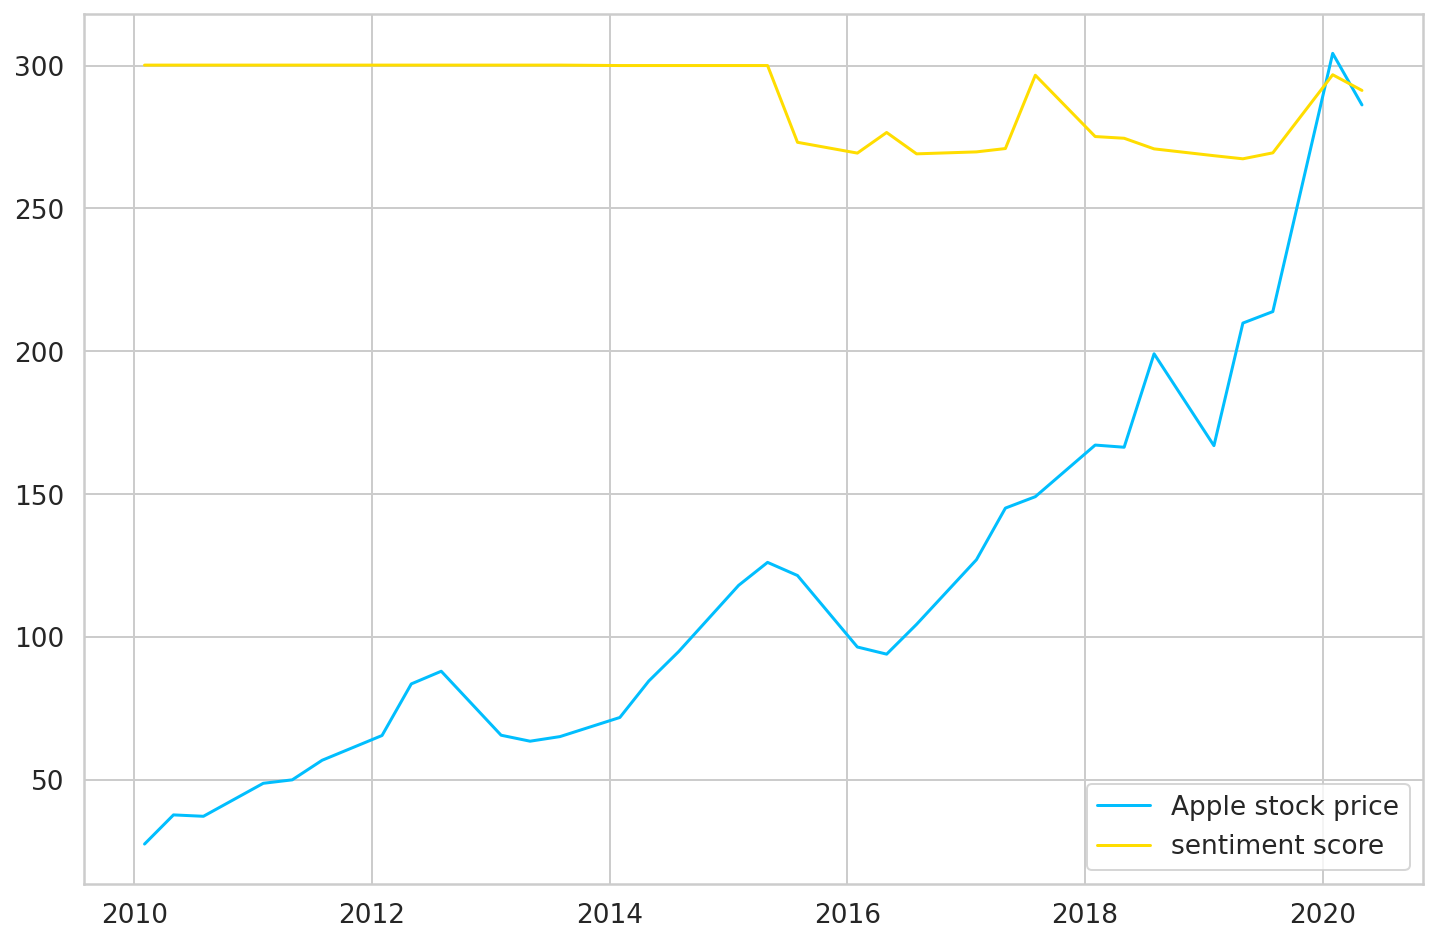

In [62]:

subset=apple[apple.index.isin(L)]


plt.plot(subset['Open'], label='linear')


plt.plot(df_apple['sentiment']*300, label='linear')

# Add a legend
plt.legend(['Apple stock price','sentiment score'])

# Show the plot
plt.show()

Now we do the same procedure for Microsoft.

In [74]:
### This the list of links for Microsoft's quarterly reports for the past 10 years. Starting from 2010

microsoft_linklist=['https://microsoft.gcs-web.com/static-files/98d1d24b-7abc-41be-9e7a-507c4db3a46d', 'https://microsoft.gcs-web.com/static-files/a6f74cc6-a9b1-42a4-845c-67b444a25628', 'https://microsoft.gcs-web.com/static-files/89d036e3-0f4d-48b1-97ce-f123575d0007',
                    'https://microsoft.gcs-web.com/static-files/df9b76bc-f768-4974-af7b-6118e522b566', 'https://microsoft.gcs-web.com/static-files/67192f73-a794-4de9-8378-783c1f277c19', 'https://microsoft.gcs-web.com/static-files/815023a5-8b1b-4718-99aa-037e1fe7e860',
                    'https://microsoft.gcs-web.com/static-files/8d1608ab-27bb-48e9-9bfa-933832b91550', 'https://microsoft.gcs-web.com/static-files/e6d1542d-e857-4a38-8b80-096c87434eba', 'https://microsoft.gcs-web.com/static-files/2f0ab4d6-035b-4e98-991b-3079838bd4c7',
                    'https://microsoft.gcs-web.com/static-files/793e5a6f-9d00-45f8-8e5f-8b4021e91d8a', 'https://microsoft.gcs-web.com/static-files/c735d2fe-bf78-442c-b748-ea0c42755c90', 'https://microsoft.gcs-web.com/static-files/7ec81b8a-5867-4df5-a579-e9c5c95d8b67',
                    'https://microsoft.gcs-web.com/static-files/ac498163-d165-42d7-ba3c-4ec3e5ec67b9', 'https://microsoft.gcs-web.com/static-files/e249e2e5-9d3e-454b-81b5-0d6b730984b3', 'https://microsoft.gcs-web.com/static-files/4dbb9842-8e4c-4ca1-99ca-8cd077e50ac5',
                    'https://microsoft.gcs-web.com/static-files/5d987373-d22d-42c5-8c1b-18f856941e18', 'https://microsoft.gcs-web.com/static-files/8c9dc027-dfd0-44c0-a2e3-c2424dbb8c85', 'https://microsoft.gcs-web.com/static-files/74bf1b6a-24ad-400c-80be-f033127ae622',
                    'https://microsoft.gcs-web.com/static-files/c032c4a0-53ea-4f4a-824a-a7e227977a2d', 'https://microsoft.gcs-web.com/static-files/282e8ff7-1607-4d85-9675-1b318bf6da16', 'https://microsoft.gcs-web.com/static-files/66cfc8ab-179b-4951-8683-04926615808d',
                    'https://microsoft.gcs-web.com/static-files/920c3783-f4b0-40ac-9dc3-bb39987e7439','https://microsoft.gcs-web.com/static-files/46d9088f-dd91-4801-93e0-254231463c78', 'https://microsoft.gcs-web.com/static-files/0bdd49ac-4eb3-4aef-be50-a77c829e24af',
                    'https://microsoft.gcs-web.com/static-files/0855f077-69cc-422b-84ea-3268db2bfbff', 'https://microsoft.gcs-web.com/static-files/b596f471-896e-4402-84fa-168bca4cce55', 'https://microsoft.gcs-web.com/static-files/28d260f4-a1d1-41e3-beae-f2dfcdd47522',
                    'https://microsoft.gcs-web.com/static-files/88061c80-0a06-40d3-962f-ad6e6d0e4625', 'https://microsoft.gcs-web.com/static-files/fb546cc4-2cbe-41c6-b6b0-85159ae6129e', 'https://microsoft.gcs-web.com/static-files/cc3da4a0-8939-45ba-a778-b0a4742a3400',
                    'https://microsoft.gcs-web.com/static-files/9c3be2d8-87da-4602-ba1c-d456eed0ea24', 'https://microsoft.gcs-web.com/static-files/ec22ab76-ae22-47f8-85d8-0bf6404cfa81']

In [ ]:
microsoft_scorelist=[]
for i in microsoft_linklist:
  j=getscore_of_pdf_link(i)
  print(j)
  microsoft_scorelist.append(j)

In [76]:
print(microsoft_scorelist)

[0.914645162972524, 0.9231559979694031, 0.9306858804822544, 0.941548578031955, 0.9591146488702319, 0.9449395625177698, 0.9544823655998176, 0.9560948504850909, 0.9020661698060608, 0.9126524249831031, 0.9378248431429822, 0.9334972326196401, 0.9480787035119976, 0.9471174757114784, 0.9431699255291919, 0.9370532355002491, 0.918136599877316, 0.9045139188894263, 0.8587373119443374, 0.8905879844212281, 0.9488979673293076, 0.9244703299778754, 0.9326771618643664, 0.9569634931589711, 0.9805196274019928, 0.9753418287480371, 0.9219287193017827, 0.9423844381741132, 0.959225572949151, 0.9063800140600711, 0.938043645467894, 0.9479753887869808]


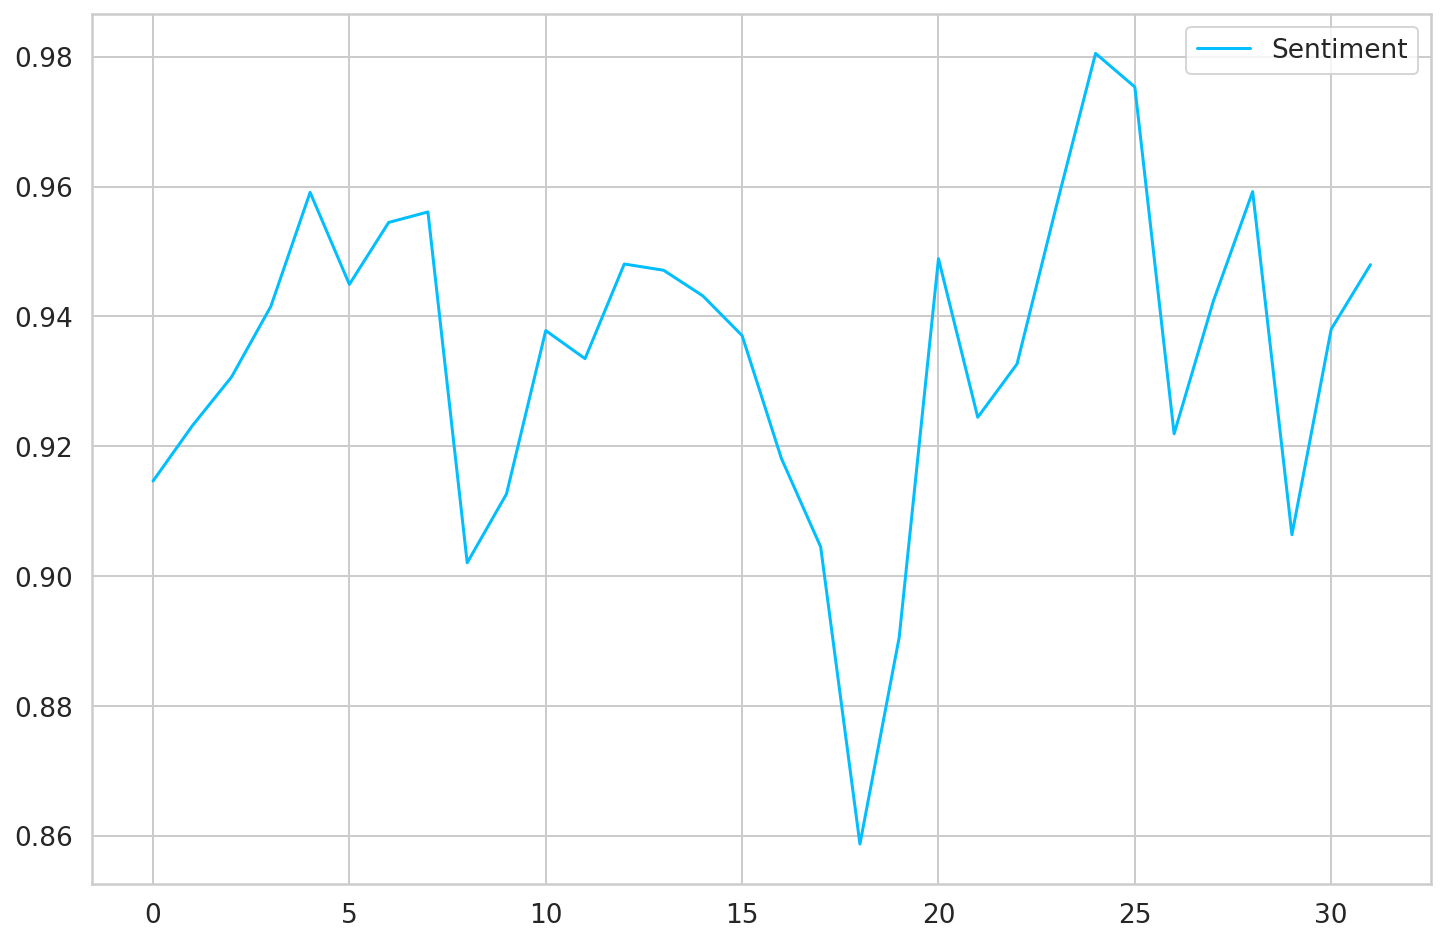

In [78]:
microsoft_scorelist=[0.914645162972524, 0.9231559979694031, 0.9306858804822544, 0.941548578031955, 0.9591146488702319, 0.9449395625177698, 0.9544823655998176, 0.9560948504850909, 0.9020661698060608, 0.9126524249831031, 0.9378248431429822, 0.9334972326196401, 0.9480787035119976, 0.9471174757114784, 0.9431699255291919, 0.9370532355002491, 0.918136599877316, 0.9045139188894263, 0.8587373119443374, 0.8905879844212281, 0.9488979673293076, 0.9244703299778754, 0.9326771618643664, 0.9569634931589711, 0.9805196274019928, 0.9753418287480371, 0.9219287193017827, 0.9423844381741132, 0.959225572949151, 0.9063800140600711, 0.938043645467894, 0.9479753887869808]

# Plot the data
plt.plot(microsoft_scorelist, label='linear')

# Add a legend
plt.legend(['Sentiment'])

# Show the plot
plt.show()

In [79]:
microsoft = web.get_data_yahoo('MSFT','01/01/2010',interval='m')
L=['2010-01-01','2010-04-01', '2010-10-01', '2011-01-01', '2011-04-01', '2011-10-01', '2012-01-01', '2012-04-01', '2012-10-01', '2013-01-01', '2013-04-01',
                                 '2013-10-01','2014-01-01', '2014-04-01', '2014-10-01', '2015-01-01', '2015-04-01', '2015-10-01',
                                 '2016-01-01','2016-04-01', '2016-10-01','2017-01-01', '2017-04-01', '2017-10-01', '2018-01-01', '2018-04-01', '2018-10-01', '2019-01-01', '2019-04-01',
                                 '2019-10-01','2020-01-01', '2020-04-01']

df_microsoft = pd.DataFrame({'date': L,'sentiment': microsoft_scorelist})
df_microsoft=df_microsoft.set_index('date')
df_microsoft.index=df_microsoft.index.astype('datetime64[ns]')

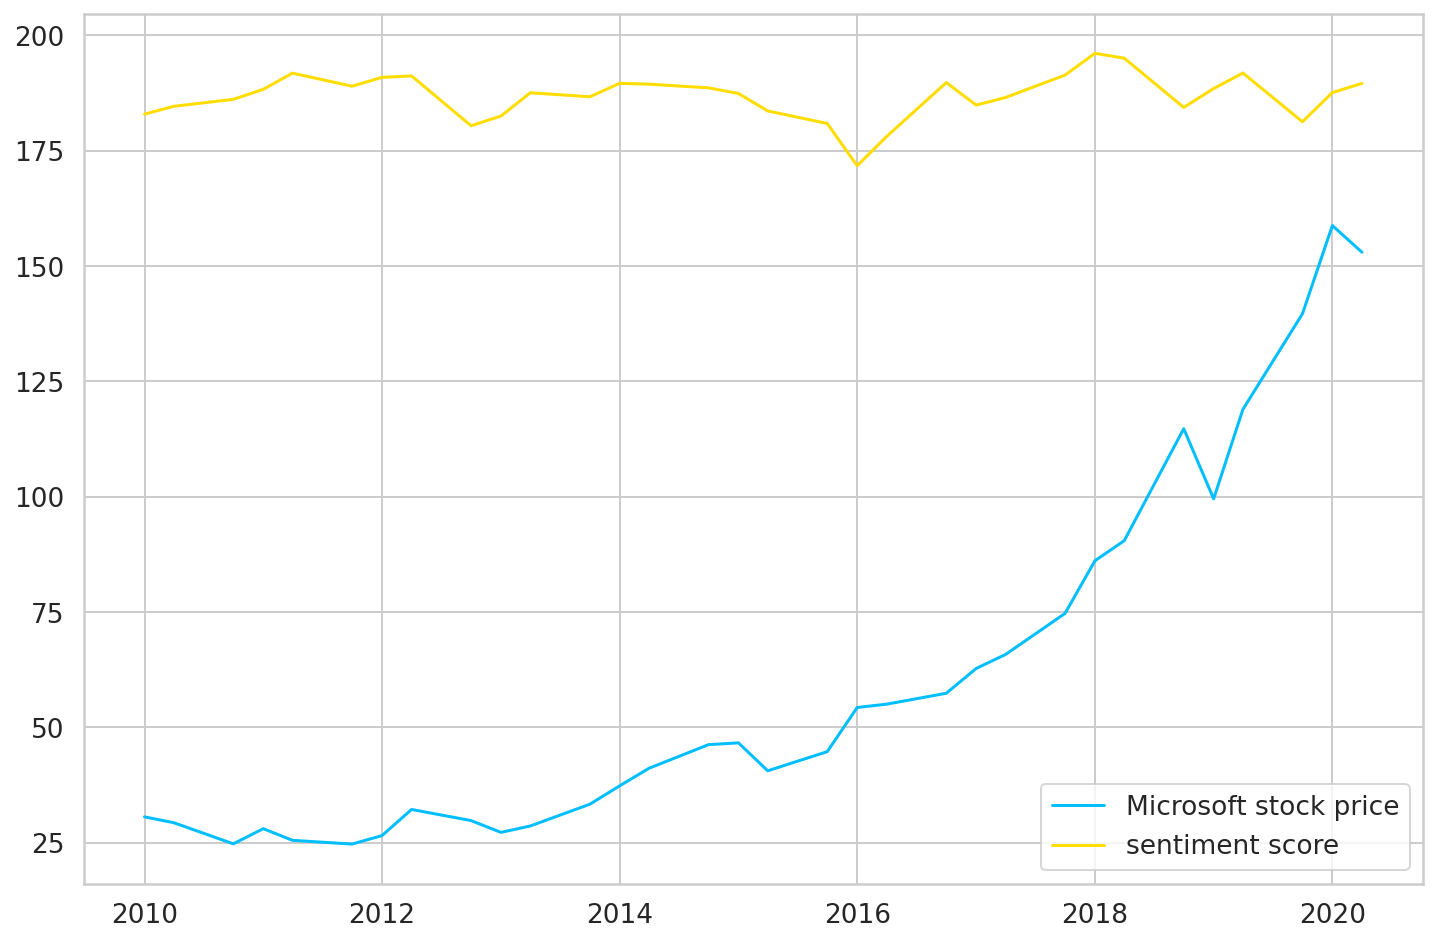

In [83]:
subset=microsoft[microsoft.index.isin(L)]


plt.plot(subset['Open'], label='linear')


plt.plot(df_microsoft['sentiment']*200, label='linear')

# Add a legend
plt.legend(['Microsoft stock price','sentiment score'])

# Show the plot
plt.show()

In [84]:
### This the list of links for Nvidia's quarterly reports for the past 10 years. Starting from 2010

nvidia_linklist=['https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2010/10Q-2010-Q1.pdf', 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2010/10Q-2010-Q2.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2010/10Q-2010-Q3.pdf', 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2011/10Q-2011-Q1.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2011/10Q-2011-Q2.pdf','https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2011/10Q-2011-Q3.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2012/10Q-2012-Q1.pdf', 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2012/10Q-2012-Q2.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2012/10Q-2012-Q3.pdf','https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2013/10Q-2013-Q1.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2013/10Q-2013-Q2.pdf', 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2013/10Q-2013-Q3.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2014/10Q-2014-Q1.pdf', 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2014/10Q-2014-Q2.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2014/10Q-2014-Q3.pdf', 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2015/10Q-2015-Q1.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2015/10Q-2015-Q2.pdf', 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2015/10Q-2015-Q3.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2016/10Q-2016-Q1.pdf', 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2016/10Q-2016-Q2.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2016/10Q-2016-Q3.pdf', 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2017/10Q-2017-Q1.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2017/10Q-2017-Q2.pdf', 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2017/10Q-2017-Q3.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2018/10Q-2018-Q1.pdf', 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2018/10Q-2018-Q2.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2018/10Q-2018-Q3.pdf', 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2019/NVIDIA-Q1Y19-Form-10Q.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2019/Q219/e21302ab-ede9-4119-ba3f-be0e61df02e3.pdf', 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2019/Q319/f949f2f3-affc-4659-a4f1-069ee8093049.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2020/Q120/e0636cad-19cc-4520-8e80-4dfc8b28d16a.pdf', 'https://s22.q4cdn.com/364334381/files/doc_financials/quarterly_reports/2020/Q220/9e501519-7cc2-40f2-aeb9-e6aace95e474.pdf',
                 'https://s22.q4cdn.com/364334381/files/doc_financials/2020/q3/cfa30c13-a603-418d-9dc7-2c52c44a276c.pdf']

In [ ]:
nvidia_scorelist=[]
for i in nvidia_linklist:
  j=getscore_of_pdf_link(i)
  print(j)
  nvidia_scorelist.append(j)

In [86]:
print(nvidia_scorelist)

[1.0006571830017492, 1.000656226533465, 1.000653998577036, 1.0006512665422633, 1.0006540884496644, 1.000653404626064, 1.0006584640359506, 1.0006511941319332, 1.000656208023429, 1.000654733274132, 1.000655860756524, 1.0006552531849593, 1.0006607924588025, 1.0006562593625858, 1.0006607855902985, 1.0006625946843997, 1.0006639026105404, 1.0006639314815402, 1.0006628733826801, 1.0006584961665794, 1.0002928707108367, 1.0256761303947617, 1.0003564818762243, 1.0003611977444962, 0.9997669285221491, 0.999765702028526, 0.9999220216122922, 0.9903695510390478, 0.996401759825797, 0.9940598693828905, 0.9550658193371977, 0.9901770708819737, 0.9524160921651114]


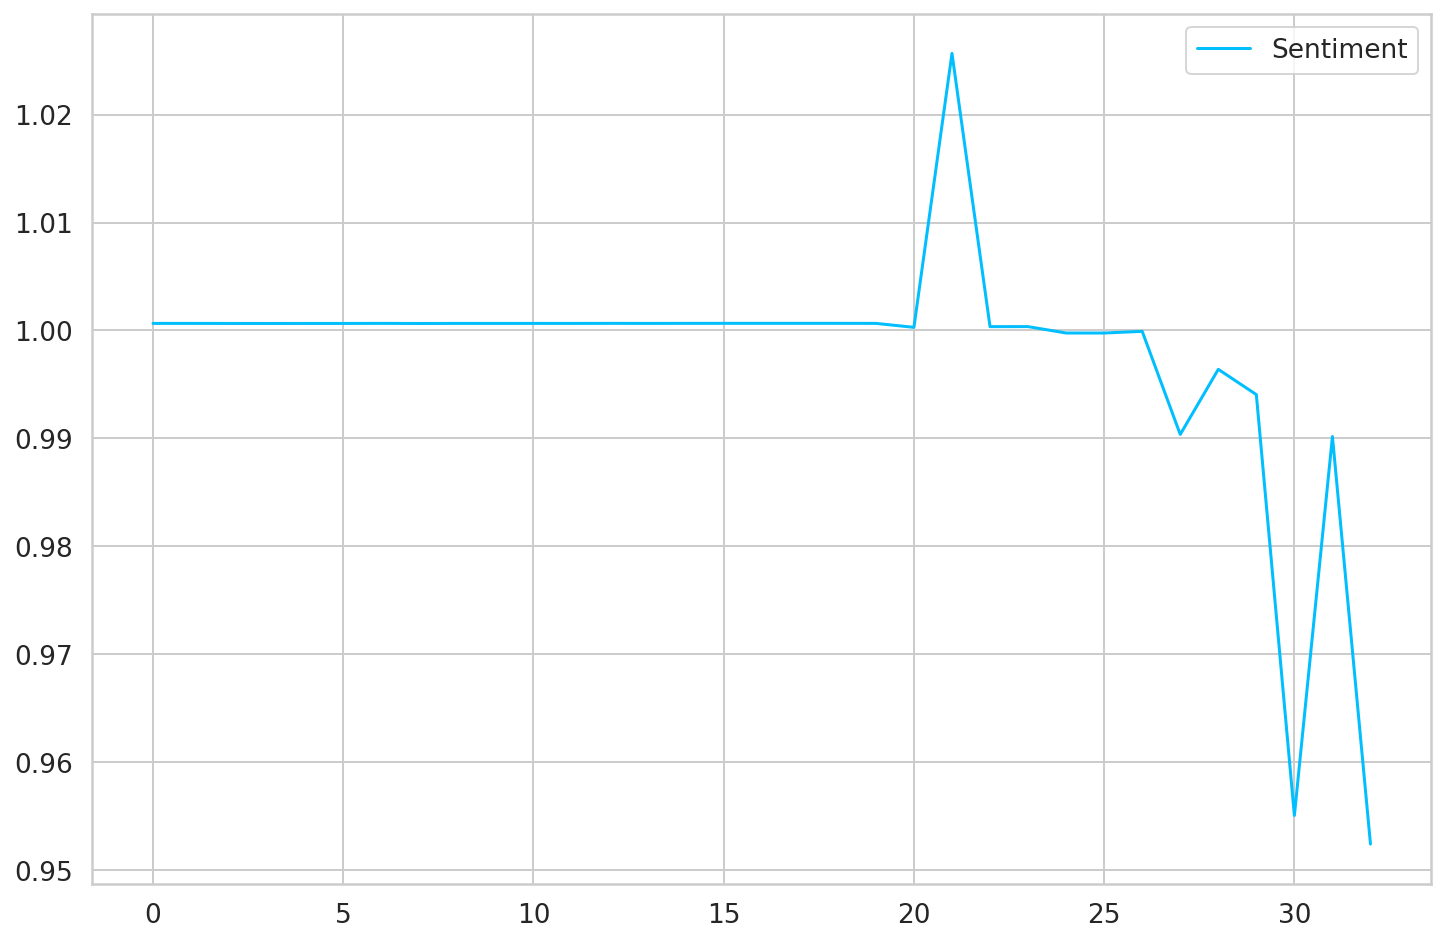

In [87]:
nvidia_scorelist=[1.0006571830017492, 1.000656226533465, 1.000653998577036, 1.0006512665422633, 1.0006540884496644, 1.000653404626064, 1.0006584640359506, 1.0006511941319332, 1.000656208023429, 1.000654733274132, 1.000655860756524, 1.0006552531849593, 1.0006607924588025, 1.0006562593625858, 1.0006607855902985, 1.0006625946843997, 1.0006639026105404, 1.0006639314815402, 1.0006628733826801, 1.0006584961665794, 1.0002928707108367, 1.0256761303947617, 1.0003564818762243, 1.0003611977444962, 0.9997669285221491, 0.999765702028526, 0.9999220216122922, 0.9903695510390478, 0.996401759825797, 0.9940598693828905, 0.9550658193371977, 0.9901770708819737, 0.9524160921651114]


# Plot the data
plt.plot(nvidia_scorelist, label='linear')

# Add a legend
plt.legend(['Sentiment'])

# Show the plot
plt.show()


In [88]:
nvidia = web.get_data_yahoo('NVDA','01/01/2010',interval='m')
L=['2010-04-01','2010-07-01', '2010-10-01', '2011-04-01', '2011-07-01', '2011-10-01', '2012-04-01', '2012-07-01', '2012-10-01', '2013-04-01', '2013-07-01',
                                 '2013-10-01','2014-04-01', '2014-07-01', '2014-10-01', '2015-04-01', '2015-07-01', '2015-10-01',
                                 '2016-04-01','2016-07-01', '2016-10-01','2017-04-01', '2017-07-01', '2017-10-01', '2018-04-01', '2018-07-01', '2018-10-01', '2019-04-01', '2019-07-01',
                                 '2019-10-01','2020-04-01', '2020-07-01', '2020-10-01']

df_nvidia = pd.DataFrame({'date': L,'sentiment': nvidia_scorelist})
df_nvidia=df_nvidia.set_index('date')
df_nvidia.index=df_nvidia.index.astype('datetime64[ns]')

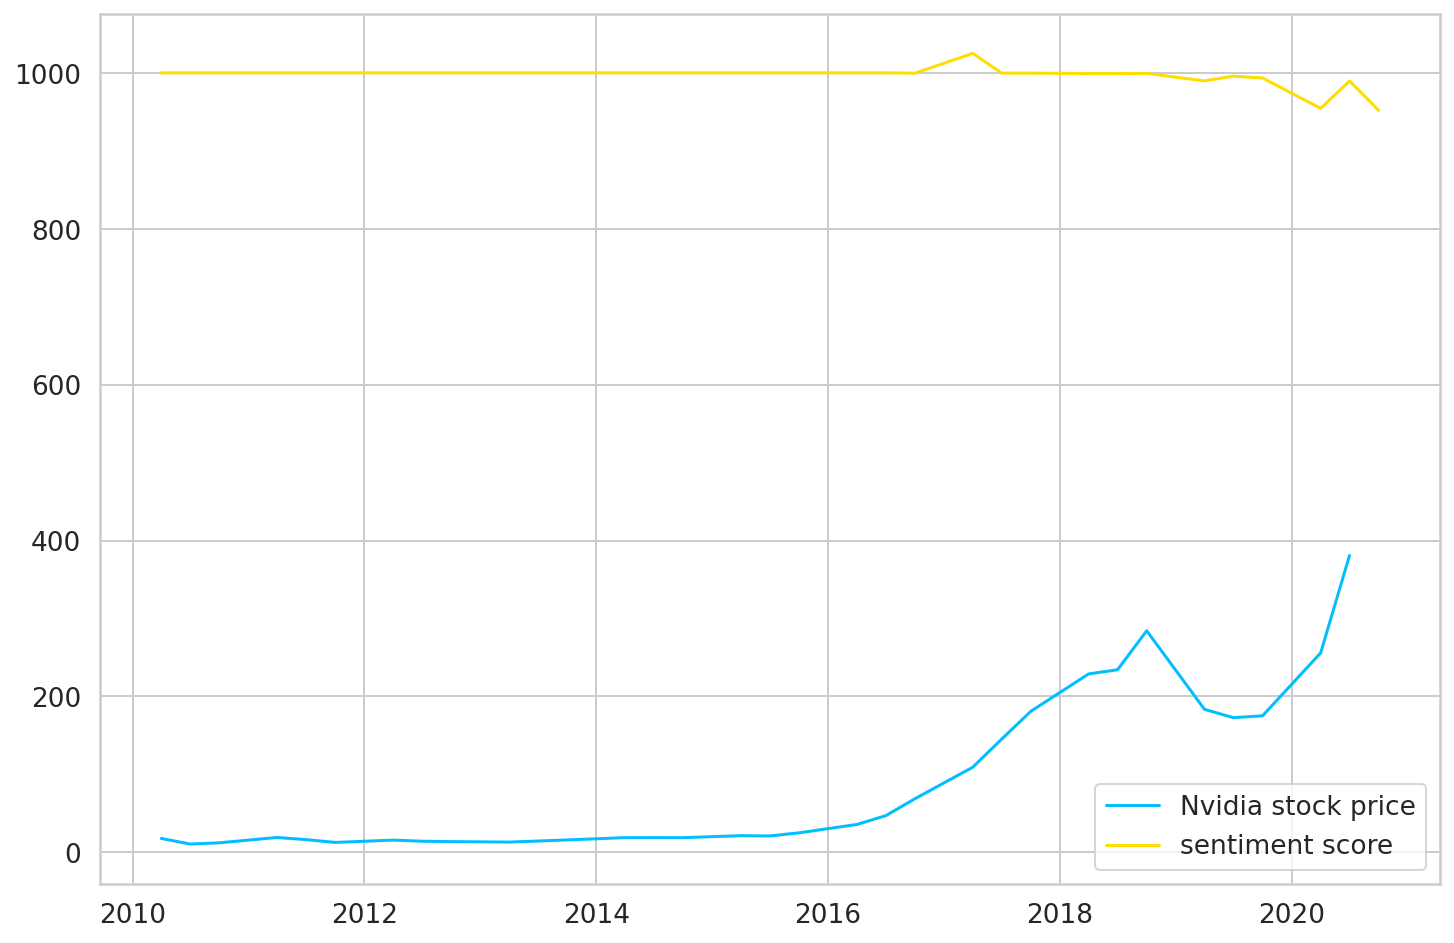

In [91]:
subset=nvidia[nvidia.index.isin(L)]


plt.plot(subset['Open'], label='linear')


plt.plot(df_nvidia['sentiment']*1000, label='linear')

# Add a legend
plt.legend(['Nvidia stock price','sentiment score'])

# Show the plot
plt.show()

In [92]:
### This part is for AMD

amd_linklist=['https://ir.amd.com/static-files/f3d25968-e2b9-4576-aaa6-0f9caf92c7a7', 'https://ir.amd.com/static-files/147e3ef8-bc11-4087-b357-626fe917809e', 'https://ir.amd.com/static-files/d82064f8-0995-4369-b06b-8604497e8395',
              'https://ir.amd.com/static-files/6a3a553f-bacf-45ff-a557-47f49228eff1', 'https://ir.amd.com/static-files/bc5064b6-3763-4126-a528-e83d24409926', 'https://ir.amd.com/static-files/9a12d4a3-bc2d-4a0b-9a70-02cd5506532a',
              'https://ir.amd.com/static-files/5a047f48-c4c2-4091-9a7f-4c7b0a091728', 'https://ir.amd.com/static-files/f29ce78f-f829-4309-90f9-493744e5de78', 'https://ir.amd.com/static-files/ad55baa4-a498-48d1-b56b-9cc4f29d5f06',
              'https://ir.amd.com/static-files/830df4e6-eb15-4785-b848-2fd48078f612', 'https://ir.amd.com/static-files/56f09f1e-4d47-4ade-9e60-1feb63adffc2', 'https://ir.amd.com/static-files/6fb80ab3-773c-4d2c-9a7e-392ddda883a7',
              'https://ir.amd.com/static-files/b14a4848-9178-4fb4-a21b-03269d1b23f7', 'https://ir.amd.com/static-files/9180f1f0-b349-4d48-acd5-959a9ceedda0', 'https://ir.amd.com/static-files/99c2c65e-67bd-4f2d-a47c-c1799bd85b27',
              'https://ir.amd.com/static-files/2208e0f0-c65f-4ef7-ad26-8939c01c1104', 'https://ir.amd.com/static-files/31f998c2-06b0-4852-91bb-862d87bbc699', 'https://ir.amd.com/static-files/677da65a-701e-4956-92d0-4dc35f32cab7',
              'https://ir.amd.com/static-files/3bc3042d-bf2d-4110-a017-de5bec1c51a6', 'https://ir.amd.com/static-files/76dd2981-0fad-40e0-b6bd-916272afdb15', 'https://ir.amd.com/static-files/5656ae85-ed70-4b0e-b089-be98f2ecf852',
              'https://ir.amd.com/static-files/0af5b854-154e-4303-bda6-21f839cbec16', 'https://ir.amd.com/static-files/dcf663ef-83fa-406b-be7d-cf95c9b8bb9e', 'https://ir.amd.com/static-files/bedae14d-e296-4183-9a0a-21a7a8bbc67f',
              'https://ir.amd.com/static-files/22c084aa-3827-454a-9b04-6d772143872c', 'https://ir.amd.com/static-files/0e3d7ce5-242f-4297-8c88-2843b31bb625', 'https://ir.amd.com/static-files/5d8f42d4-c415-4926-ad94-df9b9392cd95',
              'https://ir.amd.com/static-files/c3a88fdd-2be3-4bce-8c32-caa9c14da566', 'https://ir.amd.com/static-files/afd5b148-6d99-4b3f-9fef-91ae2953349f', 'https://ir.amd.com/static-files/69597a85-7feb-4846-beb2-fad79668d715',
              'https://ir.amd.com/static-files/4e6879be-bf96-4e2d-a153-46e400820f53']

In [ ]:
amd_scorelist=[]
for i in amd_linklist:
  j=getscore_of_pdf_link(i)
  print(j)
  amd_scorelist.append(j)

In [94]:
print(amd_scorelist)

[0.8580372045960263, 0.9238084249395447, 0.8794570264812936, 0.9011272374865233, 0.8652644087052601, 0.9051827845602971, 0.8531343528259074, 0.8070853941406575, 0.8174978159165914, 0.9234701772846247, 0.8420628947482548, 0.8424408466249166, 0.8458774945484122, 0.847015794503226, 0.92069663109988, 0.7852548059331681, 0.8420948035865061, 0.8920004887047623, 0.798266244315448, 0.8643426942936248, 0.9192489055003543, 0.8833007343410101, 0.8601462736874058, 0.8724043712235195, 0.8323961280348603, 0.833992548474204, 0.8422091491464848, 0.8241514779358621, 0.7881581452701785, 0.89583840310504, 0.788701685311845]


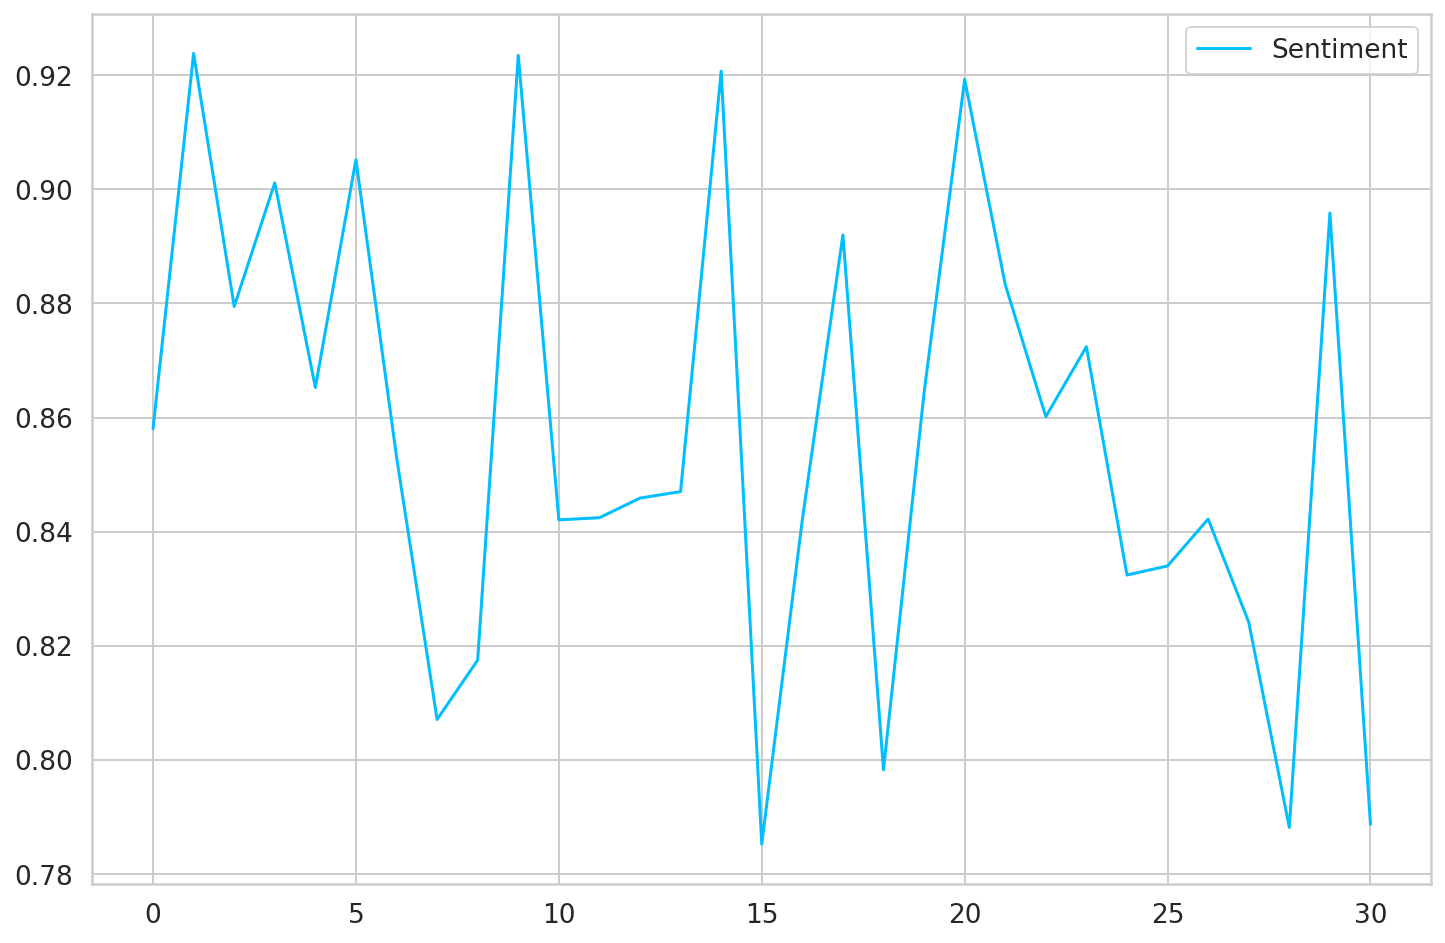

In [96]:
amd_scorelist=[0.8580372045960263, 0.9238084249395447, 0.8794570264812936, 0.9011272374865233, 0.8652644087052601, 0.9051827845602971, 0.8531343528259074, 0.8070853941406575, 0.8174978159165914, 0.9234701772846247, 0.8420628947482548, 0.8424408466249166, 0.8458774945484122, 0.847015794503226, 0.92069663109988, 0.7852548059331681, 0.8420948035865061, 0.8920004887047623, 0.798266244315448, 0.8643426942936248, 0.9192489055003543, 0.8833007343410101, 0.8601462736874058, 0.8724043712235195, 0.8323961280348603, 0.833992548474204, 0.8422091491464848, 0.8241514779358621, 0.7881581452701785, 0.89583840310504, 0.788701685311845]

# Plot the data
plt.plot(amd_scorelist, label='linear')

# Add a legend
plt.legend(['Sentiment'])

# Show the plot
plt.show()

In [98]:
amd = web.get_data_yahoo('AMD','01/01/2010',interval='m')
L=['2010-05-01','2010-07-01', '2010-10-01', '2011-05-01', '2011-07-01', '2011-10-01', '2012-05-01', '2012-07-01', '2012-10-01', '2013-05-01', '2013-07-01',
                                 '2013-10-01','2014-05-01', '2014-07-01', '2014-10-01', '2015-05-01', '2015-07-01', '2015-10-01',
                                 '2016-05-01','2016-07-01', '2016-10-01','2017-05-01', '2017-07-01', '2017-10-01', '2018-05-01', '2018-07-01', '2018-10-01', '2019-05-01', '2019-07-01',
                                 '2019-10-01','2020-05-01']

df_amd = pd.DataFrame({'date': L,'sentiment': amd_scorelist})
df_amd=df_amd.set_index('date')
df_amd.index=df_amd.index.astype('datetime64[ns]')

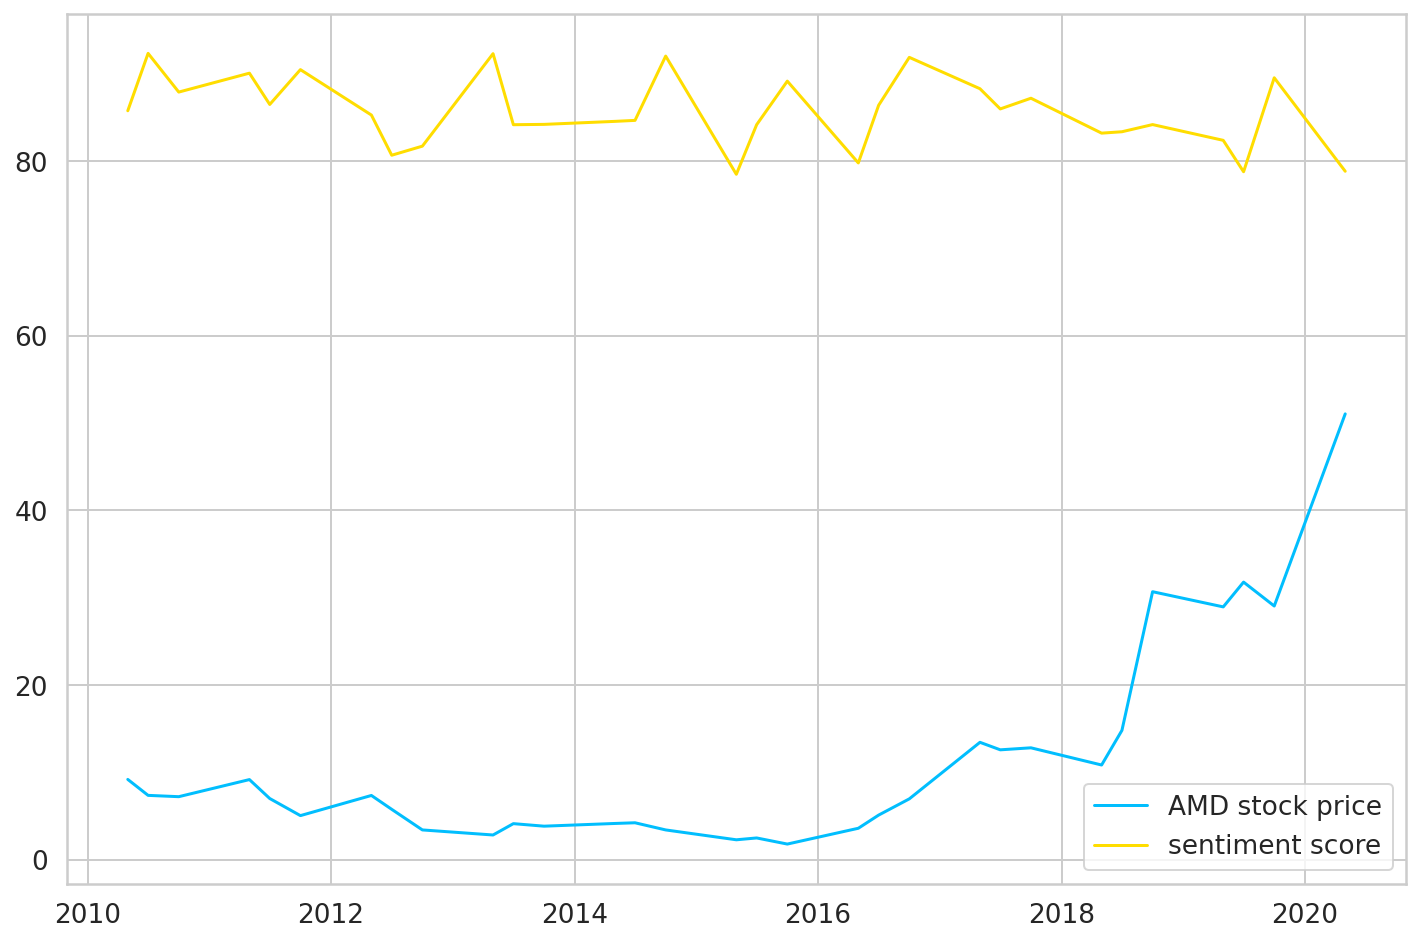

In [103]:
subset=amd[amd.index.isin(L)]


plt.plot(subset['Open'], label='linear')


plt.plot(df_amd['sentiment']*100, label='linear')

# Add a legend
plt.legend(['AMD stock price','sentiment score'])

# Show the plot
plt.show()